<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Bintangor/Bintangor_SAPX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_bintangor"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [4]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_bintangor
Rows: 11548
Columns: 16
Shape: (11548, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
4.864101409912109

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,11548.0,5.680615,3.949815,0.000000,2.600000,5.075000,8.000000,23.000000
To,11548.0,6.448785,3.934414,0.200000,3.000000,6.000000,9.000000,23.900000
Interval,11548.0,0.768170,0.290259,0.050000,0.500000,1.000000,1.000000,3.000000
CoreRec,11548.0,1.081167,0.188022,0.200000,1.000000,1.000000,1.090000,3.500000
WetW,11548.0,4.179988,1.862441,0.400000,2.640000,4.259500,5.515000,13.340000
H2O,11548.0,25.032835,14.841084,0.079000,12.402250,25.364500,36.083250,90.147000
DryW,11548.0,3.181767,1.628951,0.156000,1.835000,3.057500,4.336000,11.840000
WTF,11548.0,1.756388,0.571895,0.195304,1.489770,1.723069,1.953043,23.925631
DTF,11548.0,1.335409,0.587918,0.123134,0.992927,1.266640,1.612504,22.471965



Unique GEN_LYR count: 5
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,5803
BRK,2925
SAP,2291
SAPX,312
LIMX,217



Unique Material count: 50
Top Material value counts:


,count
Material,
YLIM,2423
Rlim,1583
ESAP,1572
HGT,933
HSAP,882
RSAP,831
Sap,700
RLIM,380
DNT,365



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [110]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: SAPX
Masukkan Material yang ingin difilter (pisahkan dengan koma): YS_1,YS_2,YS_3,YS_4,YS_5,YS_6,YS_7,BS_1,BS_2,GRAV_1,GRAV_2,YS_8,YS_9,GS_1,GS_2,GS_3,GS_4,GS_5,GS_6,GS_7,GS_8,ESAP,RSAP,Rlim,Ylim,Ylimx,Esapx,Sap,Rsapx,Sapx,Hsap

Filtered rows: 238


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740
799,CD02492,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,4.146,21.569,3.252,BS_1,None,SAP,SAPX,1.418094,1.112230
800,CD02473,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,0.35,0.35,1.00,1.293,35.750,0.831,BS_1,None,SAP,SAPX,1.263590,0.811857
801,CD02483,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,0.50,0.50,1.00,1.706,33.151,1.140,BS_1,None,SAP,SAPX,1.167037,0.780156
804,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.00,5.930,28.162,4.260,Rlim,None,SAP,SAPX,2.028292,1.457086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8282,CS7210168,Bintangor Blok 1 Spasi 50,BINTANGOR,7.9,8.54,0.64,1.59,3.070,52.443,1.460,Sap,None,SAP,SAPX,1.031898,0.490740
8601,CS6210047,Bintangor Blok 2 Spasi 25,BINTANGOR,8.0,9.00,1.00,1.00,4.562,38.185,2.820,ESAP,None,ESAP,SAPX,1.560382,0.964550
8602,CS6210028,Bintangor Blok 2 Spasi 25,BINTANGOR,8.0,9.00,1.00,1.30,6.444,34.637,4.212,ESAP,None,ESAP,SAPX,1.695461,1.108206
8629,CS6210030,Bintangor Blok 2 Spasi 25,BINTANGOR,8.0,9.00,1.00,1.30,6.211,33.473,4.132,YLIM,None,LIM,SAPX,1.634157,1.087158


# Filter By Interval

Descriptive statistics for Interval:
Count: 238
Mean: 0.747857
Standard Error: 0.018932
Median: 0.805
Mode: 1.0
Standard Deviation: 0.292074
Sample Variance: 0.085307
Kurtosis: -1.169566
Skewness: -0.273877
Range: 1.21
Minimum: 0.19
Maximum: 1.4
Sum: 177.99
Confidence Level (95%): ±0.037297

Bin calculation:
Freedman–Diaconis -> bins: 8, bin width: 0.161364
Sturges -> bins: 9, bin width: 0.134444


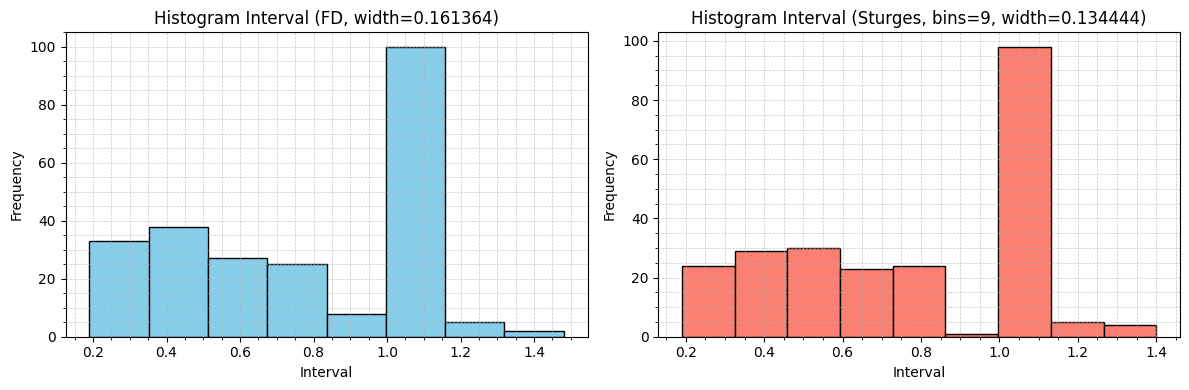


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.190000,0.351364,33
1,0.351364,0.512729,38
2,0.512729,0.674093,27
3,0.674093,0.835458,25
4,0.835458,0.996822,8
5,0.996822,1.158186,100
6,1.158186,1.319551,5
7,1.319551,1.480915,2



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.190000,0.324444,24
1,0.324444,0.458889,29
2,0.458889,0.593333,30
3,0.593333,0.727778,23
4,0.727778,0.862222,24
5,0.862222,0.996667,1
6,0.996667,1.131111,98
7,1.131111,1.265556,5
8,1.265556,1.400000,4


In [111]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [112]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.996822
Masukkan batas atas (is less than or equal to): 1.158186

Filtered rows: 100


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740
799,CD02492,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,4.146,21.569,3.252,BS_1,None,SAP,SAPX,1.418094,1.112230
804,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.00,5.930,28.162,4.260,Rlim,None,SAP,SAPX,2.028292,1.457086
805,CD00069,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,0.90,2.221,23.855,1.691,BS_1,None,SAP,SAPX,0.844119,0.642751
806,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.00,4.480,29.911,3.140,Rlim,None,SAP,SAPX,1.532335,1.074003
808,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.00,3.346,12.975,2.912,BS_1,None,SAP,SAPX,1.144463,0.995964
1714,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,1.0,2.00,1.00,1.15,6.180,34.466,4.050,Rlim,None,SAP,SAPX,1.838088,1.204572
1717,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.00,1.00,1.00,4.412,24.390,3.336,YS_1,None,SAP,SAPX,1.509076,1.141009
1721,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.00,1.00,1.00,3.222,15.850,2.711,GRAV_2,None,SAP,SAPX,1.102050,0.927373
1974,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.00,1.00,1.00,6.410,33.853,4.240,YLIM,None,ESAP,SAPX,2.192470,1.450246


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 100
Mean: 1.121700
Standard Error: 0.019547
Median: 1.0
Mode: 1.0
Standard Deviation: 0.195474
Sample Variance: 0.038210
Kurtosis: 0.629986
Skewness: 0.636451
Range: 1.2
Minimum: 0.5
Maximum: 1.7
Sum: 112.17
Confidence Level (95%): ±0.038786

Bin calculation:
Freedman–Diaconis -> bins=12, width=0.107722
Sturges -> bins=8, width=0.150000


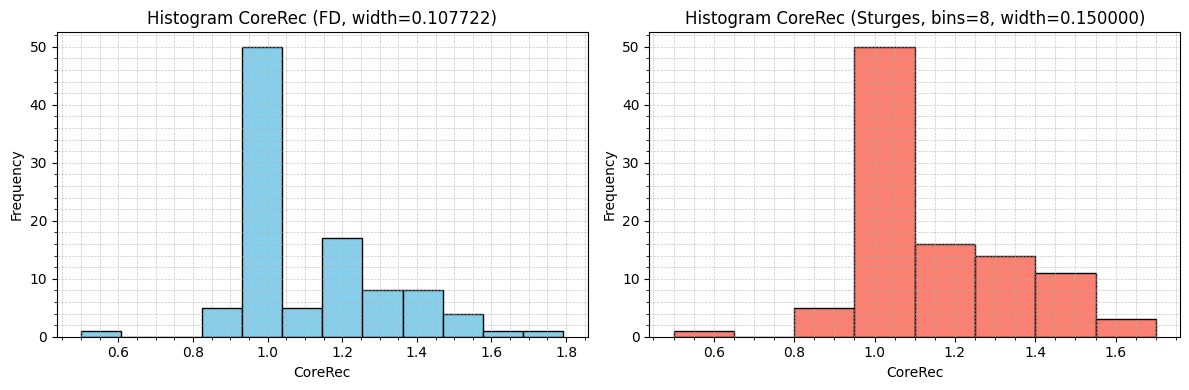


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.500000,0.607722,1
1,0.607722,0.715443,0
2,0.715443,0.823165,0
3,0.823165,0.930887,5
4,0.930887,1.038609,50
5,1.038609,1.146330,5
6,1.146330,1.254052,17
7,1.254052,1.361774,8
8,1.361774,1.469496,8
9,1.469496,1.577217,4



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.50,0.65,1
1,0.65,0.80,0
2,0.80,0.95,5
3,0.95,1.10,50
4,1.10,1.25,16
5,1.25,1.40,14
6,1.40,1.55,11
7,1.55,1.70,3


In [113]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [114]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.95
Masukkan batas atas (is less than or equal to): 1.10

Filtered rows: 55


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.00,1.00,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740
799,CD02492,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.00,1.00,4.146,21.569,3.252,BS_1,None,SAP,SAPX,1.418094,1.112230
804,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,0.00,1.00,1.00,1.00,5.930,28.162,4.260,Rlim,None,SAP,SAPX,2.028292,1.457086
806,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,0.00,1.00,1.00,1.00,4.480,29.911,3.140,Rlim,None,SAP,SAPX,1.532335,1.074003
808,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.00,1.00,3.346,12.975,2.912,BS_1,None,SAP,SAPX,1.144463,0.995964
1717,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,1.00,2.00,1.00,1.00,4.412,24.390,3.336,YS_1,None,SAP,SAPX,1.509076,1.141009
1721,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,1.00,2.00,1.00,1.00,3.222,15.850,2.711,GRAV_2,None,SAP,SAPX,1.102050,0.927373
1974,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,2.00,3.00,1.00,1.00,6.410,33.853,4.240,YLIM,None,ESAP,SAPX,2.192470,1.450246
2005,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,2.00,3.00,1.00,1.00,3.936,27.419,2.857,YS_1,None,LIM,SAPX,1.346266,0.977128
2693,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,2.00,3.00,1.00,1.10,5.240,44.847,2.890,YLIM,None,SAP,SAPX,1.629350,0.898630


# Filter By Wet Weight


Residual IQR acuan:
Q1: -0.425, Q3: 0.186, IQR: 0.611
Lower margin: -1.341, Upper margin: 1.102


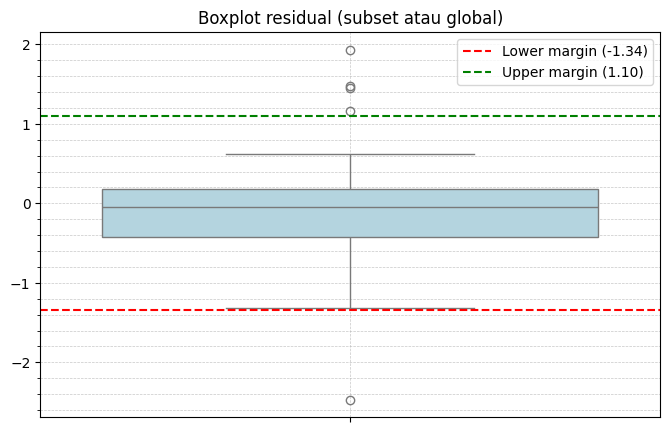

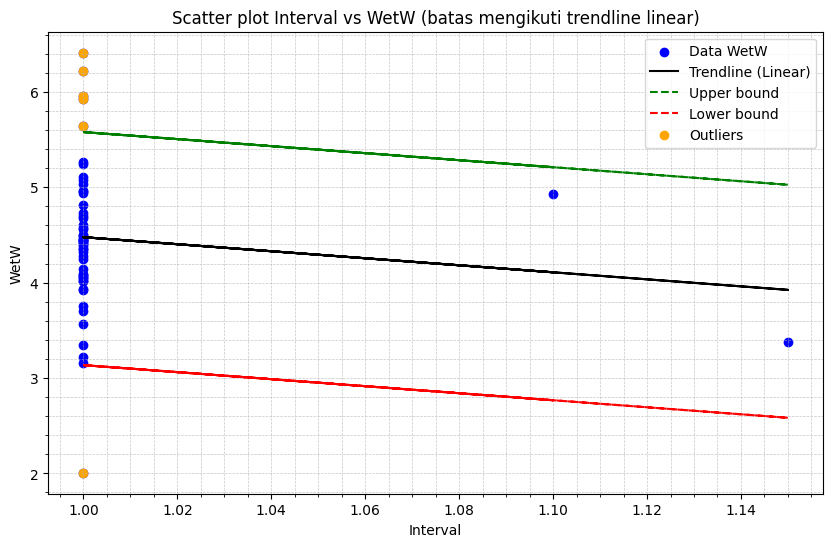


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
          HoleId                       Hill Hill_Group  From    To  Interval  \
804    CS7210154  Bintangor Blok 1 Spasi 50  BINTANGOR   0.0   1.0       1.0   
1974   CS7210154  Bintangor Blok 1 Spasi 50  BINTANGOR   2.0   3.0       1.0   
7819     CD02430    BINTANGOR BARAT SELATAN  BINTANGOR   7.0   8.0       1.0   
10106  CS6210031  Bintangor Blok 2 Spasi 25  BINTANGOR  10.0  11.0       1.0   
10833  CS6210026  Bintangor Blok 2 Spasi 25  BINTANGOR  12.0  13.0       1.0   

       CoreRec   WetW     H2O   DryW Material Layer NEW_LYR GEN_LYR       WTF  \
804        1.0  5.930  28.162  4.260     Rlim  None     SAP    SAPX  2.028292   
1974       1.0  6.410  33.853  4.240     YLIM  None    ESAP    SAPX  2.192470   
7819       1.0  2.007  23.148  1.542     YS_6  None     SAP    SAPX  0.686472   
10106      1.0  5.957  27.984  4.290     RSAP  None     SAP    SAPX  2.037527   
10833      1.0  5.637  25.457  4.202      Sap  No

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [116]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.00,1.00,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740,4.021000
799,CD02492,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.00,1.00,4.146,21.569,3.252,BS_1,None,SAP,SAPX,1.418094,1.112230,4.146000
804,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,0.00,1.00,1.00,1.00,5.930,28.162,4.260,Rlim,None,SAP,SAPX,2.028292,1.457086,5.930000
806,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,0.00,1.00,1.00,1.00,4.480,29.911,3.140,Rlim,None,SAP,SAPX,1.532335,1.074003,4.480000
808,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.00,1.00,3.346,12.975,2.912,BS_1,None,SAP,SAPX,1.144463,0.995964,3.346000
1717,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,1.00,2.00,1.00,1.00,4.412,24.390,3.336,YS_1,None,SAP,SAPX,1.509076,1.141009,4.412000
1721,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,1.00,2.00,1.00,1.00,3.222,15.850,2.711,GRAV_2,None,SAP,SAPX,1.102050,0.927373,3.222000
1974,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,2.00,3.00,1.00,1.00,6.410,33.853,4.240,YLIM,None,ESAP,SAPX,2.192470,1.450246,6.410000
2005,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,2.00,3.00,1.00,1.00,3.936,27.419,2.857,YS_1,None,LIM,SAPX,1.346266,0.977128,3.936000
2693,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,2.00,3.00,1.00,1.10,5.240,44.847,2.890,YLIM,None,SAP,SAPX,1.629350,0.898630,5.240000



Residual IQR acuan:
Q1: -0.433, Q3: 0.177, IQR: 0.611
Lower margin: -1.350, Upper margin: 1.093


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


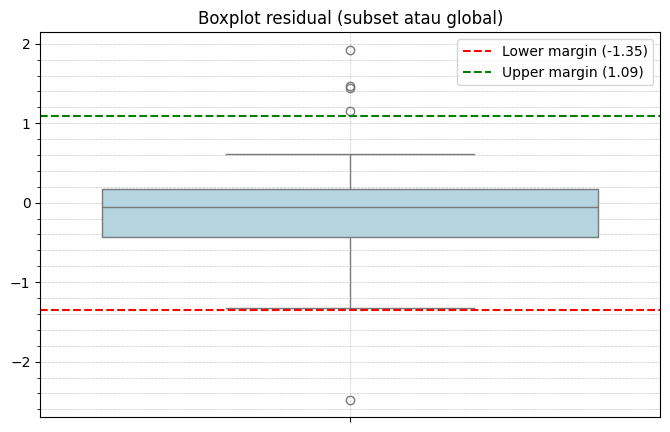

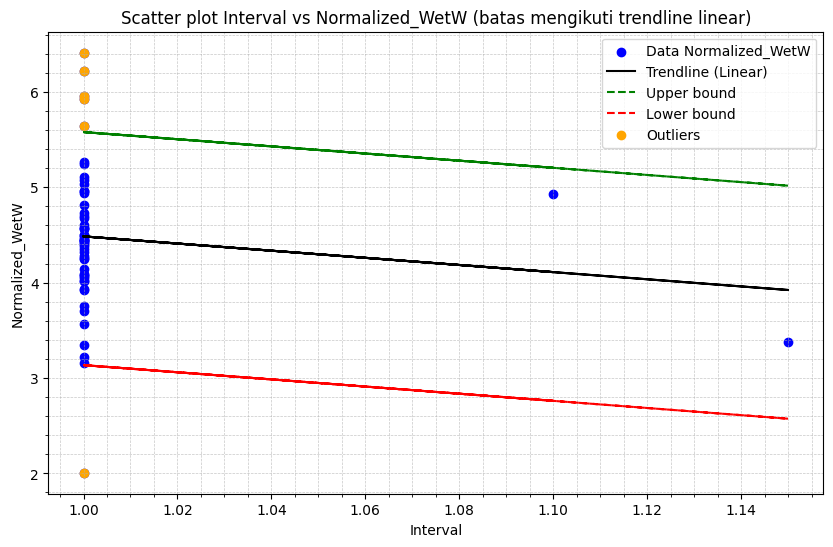

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740,4.021,4.484629,Normal
799,CD02492,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,4.146,21.569,3.252,BS_1,None,SAP,SAPX,1.418094,1.112230,4.146,4.484629,Normal
804,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,5.930,28.162,4.260,Rlim,None,SAP,SAPX,2.028292,1.457086,5.930,4.484629,Outlier atas
806,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,4.480,29.911,3.140,Rlim,None,SAP,SAPX,1.532335,1.074003,4.480,4.484629,Normal
808,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,3.346,12.975,2.912,BS_1,None,SAP,SAPX,1.144463,0.995964,3.346,4.484629,Normal
1717,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.00,1.00,1.0,4.412,24.390,3.336,YS_1,None,SAP,SAPX,1.509076,1.141009,4.412,4.484629,Normal
1721,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.00,1.00,1.0,3.222,15.850,2.711,GRAV_2,None,SAP,SAPX,1.102050,0.927373,3.222,4.484629,Normal
1974,CS7210154,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.00,1.00,1.0,6.410,33.853,4.240,YLIM,None,ESAP,SAPX,2.192470,1.450246,6.410,4.484629,Outlier atas
2005,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,2.0,3.00,1.00,1.0,3.936,27.419,2.857,YS_1,None,LIM,SAPX,1.346266,0.977128,3.936,4.484629,Normal
2693,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.00,1.00,1.1,5.240,44.847,2.890,YLIM,None,SAP,SAPX,1.629350,0.898630,5.240,4.484629,Normal


In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=11, width=0.425196
Sturges -> bins=7, width=0.629000


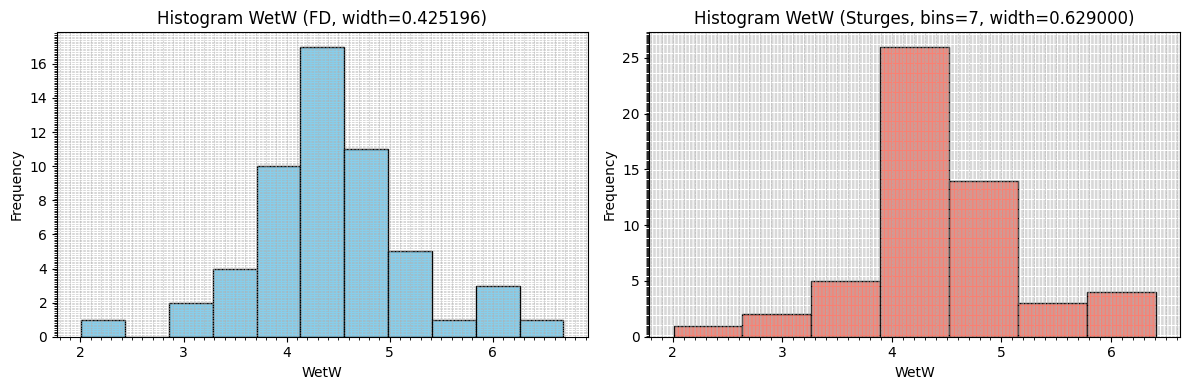


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,2.007000,2.432196,1
1,2.432196,2.857392,0
2,2.857392,3.282588,2
3,3.282588,3.707784,4
4,3.707784,4.132980,10
5,4.132980,4.558176,17
6,4.558176,4.983372,11
7,4.983372,5.408568,5
8,5.408568,5.833764,1
9,5.833764,6.258960,3



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,2.007,2.636,1
1,2.636,3.265,2
2,3.265,3.894,5
3,3.894,4.523,26
4,4.523,5.152,14
5,5.152,5.781,3
6,5.781,6.410,4


In [118]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [119]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 3.282588
Masukkan batas atas (<=): 5.408568

Filtered rows (Normal only): 47


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740,4.021,4.484629
799,CD02492,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,4.146,21.569,3.252,BS_1,None,SAP,SAPX,1.418094,1.112230,4.146,4.484629
806,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,4.480,29.911,3.140,Rlim,None,SAP,SAPX,1.532335,1.074003,4.480,4.484629
808,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,3.346,12.975,2.912,BS_1,None,SAP,SAPX,1.144463,0.995964,3.346,4.484629
1717,CD02501,BINTANGOR BARAT SELATAN,BINTANGOR,1.0,2.00,1.00,1.0,4.412,24.390,3.336,YS_1,None,SAP,SAPX,1.509076,1.141009,4.412,4.484629
2005,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,2.0,3.00,1.00,1.0,3.936,27.419,2.857,YS_1,None,LIM,SAPX,1.346266,0.977128,3.936,4.484629
2693,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,2.0,3.00,1.00,1.1,5.240,44.847,2.890,YLIM,None,SAP,SAPX,1.629350,0.898630,5.240,4.484629
3689,CD00060,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.00,1.00,1.0,4.325,30.241,3.017,YS_1,None,SAP,SAPX,1.479319,1.031955,4.325,4.484629
4678,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,4.0,5.15,1.15,1.0,3.380,35.858,2.168,YLIM,None,SAP,SAPX,1.005297,0.644818,3.380,3.922672
4721,CS6210046R,Bintangor Blok 2 Spasi 25,BINTANGOR,4.0,5.00,1.00,1.1,5.034,37.187,3.162,Rlim,None,SAP,SAPX,1.565295,0.983207,5.034,4.484629


#Filter By MC


Descriptive statistics for H2O:
Count: 47
Mean: 34.671085
Standard Error: 1.282519
Median: 36.739
Mode: 12.975
Standard Deviation: 8.792509
Sample Variance: 77.308211
Kurtosis: -0.195414
Skewness: -0.614195
Range: 36.235
Minimum: 12.975
Maximum: 49.21
Sum: 1629.5409999999997
Confidence Level (95%): ±2.581577

Bin calculation:
Freedman–Diaconis -> bins=6, width=6.266304
Sturges -> bins=7, width=5.176429


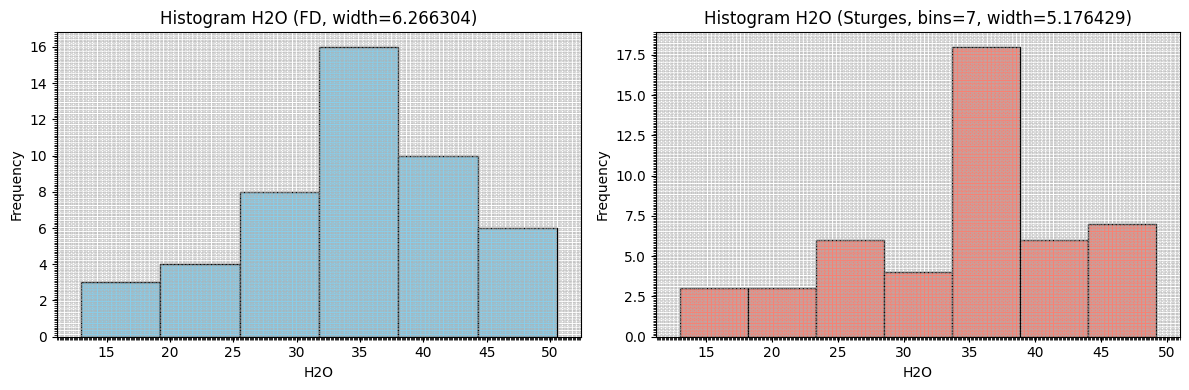


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,12.975000,19.241304,3
1,19.241304,25.507607,4
2,25.507607,31.773911,8
3,31.773911,38.040215,16
4,38.040215,44.306518,10
5,44.306518,50.572822,6



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,12.975000,18.151429,3
1,18.151429,23.327857,3
2,23.327857,28.504286,6
3,28.504286,33.680714,4
4,33.680714,38.857143,18
5,38.857143,44.033571,6
6,44.033571,49.210000,7


In [120]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [121]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 25.507607
is less than or equal to: 44.306518

Filtered rows (H2O): 34


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.0,1.00,1.00,1.0,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740,4.021,4.484629
806,CS7210161,Bintangor Blok 1 Spasi 50,BINTANGOR,0.0,1.00,1.00,1.0,4.480,29.911,3.140,Rlim,None,SAP,SAPX,1.532335,1.074003,4.480,4.484629
2005,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,2.0,3.00,1.00,1.0,3.936,27.419,2.857,YS_1,None,LIM,SAPX,1.346266,0.977128,3.936,4.484629
3689,CD00060,BINTANGOR BARAT SELATAN,BINTANGOR,3.0,4.00,1.00,1.0,4.325,30.241,3.017,YS_1,None,SAP,SAPX,1.479319,1.031955,4.325,4.484629
4678,CS7210094,Bintangor Blok 2 Spasi 50,BINTANGOR,4.0,5.15,1.15,1.0,3.380,35.858,2.168,YLIM,None,SAP,SAPX,1.005297,0.644818,3.380,3.922672
4721,CS6210046R,Bintangor Blok 2 Spasi 25,BINTANGOR,4.0,5.00,1.00,1.1,5.034,37.187,3.162,Rlim,None,SAP,SAPX,1.565295,0.983207,5.034,4.484629
5721,CS6210031,Bintangor Blok 2 Spasi 25,BINTANGOR,5.0,6.00,1.00,1.0,5.102,39.436,3.090,YLIM,None,SAP,SAPX,1.745083,1.056901,5.102,4.484629
5756,CS7210002R,Bintangor Blok 2 Spasi 50,BINTANGOR,5.0,6.00,1.00,1.0,4.496,34.831,2.930,YLIM,None,SAP,SAPX,1.537808,1.002174,4.496,4.484629
5760,CS6210040,Bintangor Blok 2 Spasi 25,BINTANGOR,5.0,6.00,1.00,1.0,4.940,36.235,3.150,YLIM,None,SAP,SAPX,1.689673,1.077423,4.940,4.484629
5768,CS7210109,Bintangor Blok 2 Spasi 50,BINTANGOR,5.0,6.00,1.00,1.0,4.502,36.739,2.848,ESAP,None,SAP,SAPX,1.539860,0.974127,4.502,4.484629


# Filter By DTF


Descriptive statistics for DTF:
Count: 34
Mean: 0.963443
Standard Error: 0.019033
Median: 0.971204311
Mode: 0.644817949
Standard Deviation: 0.110979
Sample Variance: 0.012316
Kurtosis: 0.863773
Skewness: -0.655486
Range: 0.514514381
Minimum: 0.644817949
Maximum: 1.15933233
Sum: 32.757070556
Confidence Level (95%): ±0.038722

Bin calculation:
Freedman–Diaconis -> bins=8, width=0.070131
Sturges -> bins=7, width=0.073502


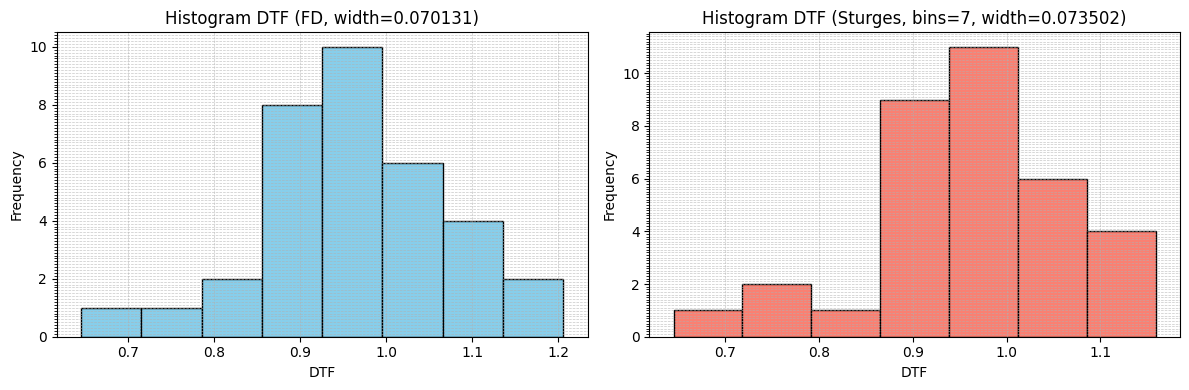


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.644818,0.714949,1
1,0.714949,0.785079,1
2,0.785079,0.855210,2
3,0.855210,0.925340,8
4,0.925340,0.995471,10
5,0.995471,1.065601,6
6,1.065601,1.135732,4
7,1.135732,1.205862,2



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.644818,0.718320,1
1,0.718320,0.791822,2
2,0.791822,0.865324,1
3,0.865324,0.938826,9
4,0.938826,1.012328,11
5,1.012328,1.085830,6
6,1.085830,1.159332,4


In [122]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [123]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 0.855210
is less than or equal to: 1.065601

Filtered rows (DTF): 24


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
2,CD02441,BINTANGOR BARAT SELATAN,BINTANGOR,0.00,1.00,1.0,1.00,4.021,30.218,2.806,GRAV_1,None,ESAP,SAPX,1.375339,0.959740,4.021000,4.484629
2005,CD02453,BINTANGOR BARAT SELATAN,BINTANGOR,2.00,3.00,1.0,1.00,3.936,27.419,2.857,YS_1,None,LIM,SAPX,1.346266,0.977128,3.936000,4.484629
3689,CD00060,BINTANGOR BARAT SELATAN,BINTANGOR,3.00,4.00,1.0,1.00,4.325,30.241,3.017,YS_1,None,SAP,SAPX,1.479319,1.031955,4.325000,4.484629
4721,CS6210046R,Bintangor Blok 2 Spasi 25,BINTANGOR,4.00,5.00,1.0,1.10,5.034,37.187,3.162,Rlim,None,SAP,SAPX,1.565295,0.983207,5.034000,4.484629
5721,CS6210031,Bintangor Blok 2 Spasi 25,BINTANGOR,5.00,6.00,1.0,1.00,5.102,39.436,3.090,YLIM,None,SAP,SAPX,1.745083,1.056901,5.102000,4.484629
5756,CS7210002R,Bintangor Blok 2 Spasi 50,BINTANGOR,5.00,6.00,1.0,1.00,4.496,34.831,2.930,YLIM,None,SAP,SAPX,1.537808,1.002174,4.496000,4.484629
5768,CS7210109,Bintangor Blok 2 Spasi 50,BINTANGOR,5.00,6.00,1.0,1.00,4.502,36.739,2.848,ESAP,None,SAP,SAPX,1.539860,0.974127,4.502000,4.484629
6805,CS6210026,Bintangor Blok 2 Spasi 25,BINTANGOR,6.00,7.00,1.0,1.00,4.810,43.202,2.732,ESAP,None,SAP,SAPX,1.645208,0.934451,4.810000,4.484629
6813,CS6210122,Bintangor Blok 2 Spasi 25,BINTANGOR,6.00,7.00,1.0,1.00,4.088,36.742,2.586,ESAP,None,SAP,SAPX,1.398256,0.884513,4.088000,4.484629
6814,CS6210047,Bintangor Blok 2 Spasi 25,BINTANGOR,6.00,7.00,1.0,1.00,4.409,38.852,2.696,YLIM,None,SAP,SAPX,1.508050,0.922137,4.409000,4.484629


# SUMMARY

In [124]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 24
Mean: 1.004167
Standard Error: 0.004167
Median: 1.0
Mode: 1.0
Standard Deviation: 0.020412
Sample Variance: 0.000417
Kurtosis: 19.043478
Skewness: 4.587317
Range: 0.10000000000000009
Minimum: 1.0
Maximum: 1.1
Sum: 24.1
Confidence Level (95%): ±0.008619

Descriptive statistics for CoreRec:
Count: 24
Mean: 1.010417
Standard Error: 0.007359
Median: 1.0
Mode: 1.0
Standard Deviation: 0.036053
Sample Variance: 0.001300
Kurtosis: 2.552344
Skewness: 1.813624
Range: 0.15000000000000013
Minimum: 0.95
Maximum: 1.1
Sum: 24.25
Confidence Level (95%): ±0.015224

Descriptive statistics for WetW:
Count: 24
Mean: 4.505792
Standard Error: 0.077000
Median: 4.474
Mode: 3.936
Standard Deviation: 0.377223
Sample Variance: 0.142297
Kurtosis: -0.848945
Skewness: 0.267400
Range: 1.3319999999999999
Minimum: 3.936
Maximum: 5.268
Sum: 108.139
Confidence Level (95%): ±0.159287

Descriptive statistics for H2O:
Count: 24
Mean: 36.505792
Standard Error: 0.908472
Median:

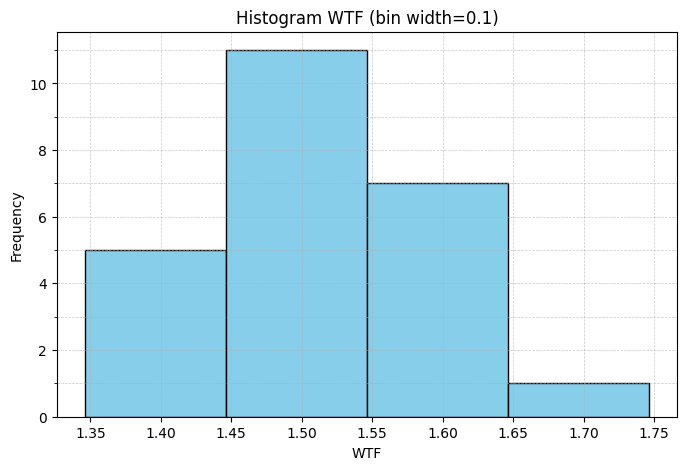


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,1.346266,1.446266,5
1,1.446266,1.546266,11
2,1.546266,1.646266,7
3,1.646266,1.746266,1


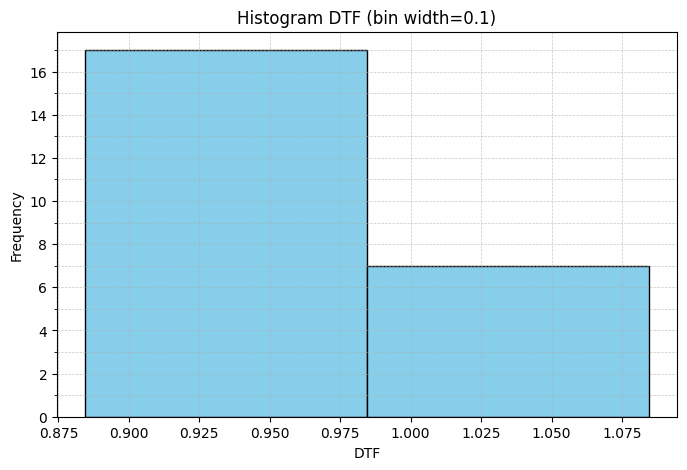


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,0.884513,0.984513,17
1,0.984513,1.084513,7


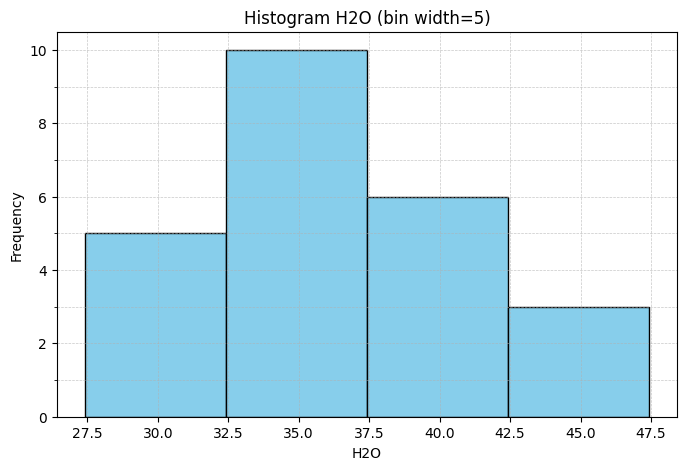


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,27.419,32.419,5
1,32.419,37.419,10
2,37.419,42.419,6
3,42.419,47.419,3


In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [126]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Bintangor
Masukkan GEN_LYR: SAPX

Tabel Ringkasan tersimpan sebagai variabel: df_bintangor_sapx


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Bintangor,SAPX,1.004167,1.010417,4.505792,36.505792,2.851667,1.518043,0.961013
